# Check pair of neurons input-output relationships

In [66]:
import os
import pandas as pd
import numpy as np
from fafbseg import flywire
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
# Choose path and file
dataPath = r'D:\Connectomics-Data\FlyWire\Txts\cell_type_proofread'
fileDate = '20230920'
pre_neuron_type = 'LC14_L'
post_neuron_type = 'LC17_R'

pre_fileName = f'root_ids_{pre_neuron_type}_{fileDate}.txt'
post_fileName = f'root_ids_{post_neuron_type}_{fileDate}.txt'
pre_filePath = os.path.join(dataPath,pre_fileName)
post_filePath = os.path.join(dataPath,post_fileName)
pre_ids_df = pd.read_csv(pre_filePath, sep = ",")
post_ids_df = pd.read_csv(post_filePath, sep = ",")

pre_ids = pre_ids_df.columns.tolist()
post_ids = post_ids_df.columns.tolist()


In [114]:
# Update all ids
#Presynaptic cell ids
update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
up_to_date_pre_ids = update_df['new_id'].tolist()

#Postsynaptic cell ids
update_df = flywire.update_ids(post_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
up_to_date_post_ids = update_df['new_id'].tolist()

Updating:   0%|          | 0/26 [00:00<?, ?it/s]

Updating:   0%|          | 0/142 [00:00<?, ?it/s]

In [115]:
# Getting inputs

# Fetch the neuron's inputs
post_inputs = flywire.synapses.fetch_synapses(up_to_date_post_ids, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

# Fetch the neuron's outputs
pre_outputs = flywire.synapses.fetch_synapses(up_to_date_pre_ids, pre= True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

Fetching synapses:   0%|          | 0/5 [00:00<?, ?it/s]

In [116]:
# Quick visualization of the weight of our presynaptic partner of interest as input of our postsynaptoc cell of interest

#Geeting all input counts for each presynaptic neuron id
post_inputs_counts = post_inputs.groupby(['post', 'pre'])['pre'].count().reset_index(name='pre_syn_count')

#Initializing variables
neuron_type_weight = []
neuron_weight = []
neuron_weight_post_ls = []
neuron_weight_pre_ls = []
#Looping to get the neuron and neuron type weigths to each postsynaptic partner
for _post in list(set(post_inputs_counts['post'].tolist())):
    curr_df = post_inputs_counts[post_inputs_counts['post'] == _post].copy()
    curr_total_syn_count = curr_df['pre_syn_count'].sum()
    curr_pre_type_df = curr_df[curr_df['pre'].isin(up_to_date_pre_ids)].copy()
    # Weitgh for all cell of the same type
    curr_neuron_type_weight = curr_pre_type_df['pre_syn_count'].sum()/curr_total_syn_count
    neuron_type_weight.append(curr_neuron_type_weight)
    # Weitgh for individual cell of the same type
    if len(curr_pre_type_df['pre']) == 0:
        neuron_weight.append(0.0)
    else:
        for _pre in list(set(curr_pre_type_df['pre'].tolist())):
            neuron_weight_post_ls.append(_post) # tracking the postsynaptic neuron ids
            neuron_weight_pre_ls.append(_pre) # tracking the presynaptic neuron ids
            curr_neuron_weight = curr_pre_type_df[curr_pre_type_df['pre'] == _pre]['pre_syn_count'].sum() / curr_total_syn_count
            neuron_weight.append(curr_neuron_weight)


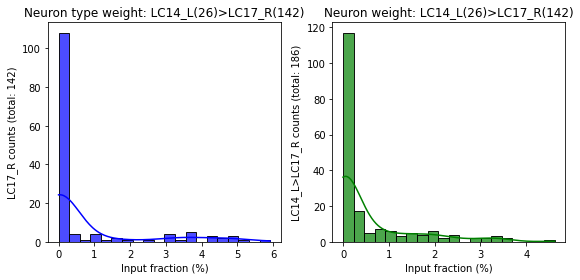

In [117]:
# Plotting 

# Calculate the percentage values
neuron_type_weight_percent = [x * 100 for x in neuron_type_weight] 
neuron_weight_percent = [x * 100 for x in neuron_weight] 

# Create subplots for each dimension using Seaborn
plt.figure(figsize=(12, 4))

plt.subplot(131)  # 1 row, 3 columns, 1st subplot
sns.histplot(neuron_type_weight_percent, bins=20, color='blue', alpha=0.7, kde=True)
plt.title(f'Neuron type weight: {pre_neuron_type}({len(pre_ids)})>{post_neuron_type}({len(post_ids)})')
plt.xlabel('Input fraction (%)')  # Update the x-axis label
plt.ylabel(f'{post_neuron_type} counts (total: {len(neuron_type_weight_percent)})')  # Update the x-axis label

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
sns.histplot(neuron_weight_percent, bins=20, color='green', alpha=0.7, kde=True)
plt.title(f'Neuron weight: {pre_neuron_type}({len(pre_ids)})>{post_neuron_type}({len(post_ids)})')
plt.xlabel('Input fraction (%)')  # Update the x-axis label
plt.ylabel(f'{pre_neuron_type}>{post_neuron_type} counts (total: {len(neuron_weight_percent)})')  # Update the x-axis label

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()